# Neurogenesis Demo
Train an autoencoder on a small MNIST subset and generate intrinsic replay samples.

In [2]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger

from data.mnist_datamodule import MNISTDataModule
from models.ng_autoencoder import NGAutoEncoder as AutoEncoder
from training.intrinsic_replay_runner import run_intrinsic_replay

In [3]:
# datamodule restricted to digits 0 and 1
dm = MNISTDataModule(batch_size=64, num_workers=0, classes=[1, 7])
dm.setup()

In [4]:
# LightningModule wrapping the AutoEncoder
class LitWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.ae = model
        self.loss_fn = torch.nn.MSELoss()
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.ae(x)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        out = self(imgs)
        loss = self.loss_fn(out["recon"], imgs.view(imgs.size(0), -1))
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        out = self(imgs)
        self._last_imgs = imgs
        self._last_recons = out["recon"].view_as(imgs)
        loss = self.loss_fn(out["recon"], imgs.view(imgs.size(0), -1))
        self.val_losses.append(loss.item())
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def on_validation_epoch_end(self):
        grid = torchvision.utils.make_grid(
            torch.cat([self._last_imgs, self._last_recons], dim=0),
            nrow=self._last_imgs.size(0),
        )
        self.example_grid = grid
        self._last_imgs = None
        self._last_recons = None

In [5]:
model = AutoEncoder(input_dim=28 * 28, hidden_sizes=[200, 100, 60, 20], activation="relu")
lit = LitWrapper(model)
logger = MLFlowLogger(experiment_name="demo")
trainer = pl.Trainer(max_epochs=20, logger=logger)
trainer.fit(lit, dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | ae      | NGAutoEncoder | 369 K  | train
1 | loss_fn | MSELoss       | 0      | train
--------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.478     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Admin\Anaconda3\envs\neurogenesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\Admin\Anaconda3\envs\neurogenesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 204/204 [00:06<00:00, 33.20it/s, v_num=c018]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 204/204 [00:06<00:00, 32.76it/s, v_num=c018]


Train losses: [0.23561206459999084, 0.23676295578479767, 0.23613157868385315, 0.23529334366321564, 0.23504622280597687, 0.23444463312625885, 0.2325747162103653, 0.23204664885997772, 0.2299719750881195, 0.22763296961784363, 0.22371770441532135, 0.21926003694534302, 0.21003086864948273, 0.200159952044487, 0.18829679489135742, 0.16806064546108246, 0.1437753587961197, 0.1163819432258606, 0.09523366391658783, 0.07639464735984802, 0.06767258048057556, 0.05449261888861656, 0.06227678060531616, 0.05448949337005615, 0.06630963832139969, 0.05486598238348961, 0.061488110572099686, 0.059203680604696274, 0.05786656588315964, 0.05940067395567894, 0.0556066669523716, 0.05886693298816681, 0.05388348177075386, 0.04939257353544235, 0.05420900881290436, 0.05380929261445999, 0.05241549015045166, 0.05168212205171585, 0.06007057800889015, 0.0556056834757328, 0.0550864152610302, 0.056408870965242386, 0.05898531898856163, 0.053481630980968475, 0.05169538035988808, 0.05551601201295853, 0.05537319928407669, 0.0

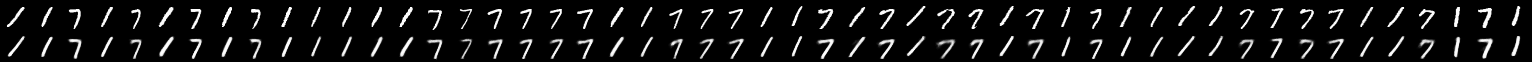

In [6]:
print("Train losses:", lit.train_losses)
print("Val losses:", lit.val_losses)
display(torchvision.transforms.ToPILImage()(lit.example_grid))

In [7]:
imgs_ir = run_intrinsic_replay(
    encoder=model.encoder,
    decoder=model.decoder,
    dataloader=dm.train_dataloader(),
    mlf_logger=logger,
    n_samples_per_class=4,
    device=trainer.strategy.root_device,
)

✅ intrinsic-replay artifacts logged under run a3fdaeac425c4d128fb17291bddbc018


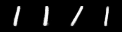

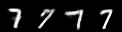

In [8]:
from torchvision.utils import make_grid

for b in imgs_ir:
    grid = make_grid(b, nrow=4, normalize=True)
    display(torchvision.transforms.ToPILImage()(grid))